# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.5 tensorflow-gpu==2.5 opencv-python matplotlib

In [79]:
!pip install --upgrade tensorflow

In [ ]:
!pip3 install matplotlib
!pip3 install keras
!pip3 install mtcnn

In [ ]:
!pip install keras==2.6

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import Dependencies for face detection and MTCNN Model
from mtcnn.mtcnn import MTCNN
from numpy import asarray
from PIL import Image

In [3]:
#Import Preprocessing packages
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [4]:
# VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16

In [5]:
#Logger for training
from tensorflow.keras.callbacks import CSVLogger

In [6]:
# Import tensorflow dependencies - Functional API
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, ZeroPadding2D, Convolution2D, Dropout, Activation
import tensorflow as tf

In [7]:
SEED = 21

In [8]:
#Shape of the input images
target_shape = (224, 224)

## 1.3 Set GPU Growth

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

IndexError: list index out of range

In [11]:
gpus

[]

In [12]:
tf.config.list_physical_devices('GPU')

[]

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# 3. Load and Preprocess Images

## 3.1 Preprocessing - Resizing, Alignment and Cropping

In [9]:
# Preprocess images
def preprocess(file_path, required_size=(224,224)):
    raw = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(raw, channels=3, dct_method='INTEGER_ACCURATE')
    image = tf.image.resize(image,required_size, method='nearest')
    image = tf.cast(image, 'float32')
    return np.array(image)

In [10]:
K = tf.keras.backend

# VGG Face preprocessing
def preprocess_input_vvgface(x, data_format=None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp

In [11]:
def complete_preprocess(image_path, required_size=(224,224)): 
    # load image and detect the face
    image = preprocess(image_path)
    
    #image = np.expand_dims(image, axis=0)
    
    #Preprocessing
    face_array = preprocess_input(image)
    
    
    # Scale image to be between 0 and 1 
    face_array = (face_array - np.amin(face_array)) / (np.amax(face_array) - np.amin(face_array))
    # Scale image to be between -1 and 1
    face_array = 2*face_array - 1
    
    return tf.convert_to_tensor(face_array)

# 3.2 Create Labelled Dataset

In [186]:
#Peparing arrays of file paths of all the data
anchor_array = []
positive_array = []
negative_array = []

#Making sure all the names appended can be cropped
for directory in os.listdir('cropped_test_data'):
    anchor_name = os.path.join('cropped_test_data',directory,'anchor.jpg')
    positive_name = os.path.join('cropped_test_data',directory,'positive.jpg')
    negative_name = os.path.join('cropped_test_data',directory,'negative.jpg')
    
    
    anchor_array.append(anchor_name)
    positive_array.append(positive_name)
    negative_array.append(negative_name)

In [187]:
data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(anchor_array), 
                            tf.data.Dataset.from_tensor_slices(positive_array), 
                            tf.data.Dataset.from_tensor_slices(negative_array)))

In [ ]:
#Making sure all the names appended can be cropped
label_idx = 0
labels = []
files = []
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        file_name = os.path.join('lfw',directory,file)
        files.append(file_name)
        labels.append(label_idx)
        print(file_name)
        print(label_idx)
    
    label_idx = label_idx + 1    

In [205]:
data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(files), 
                            tf.data.Dataset.from_tensor_slices(labels)))

# 3.4 Build Train and Test Partition

In [210]:
def preprocess_dataset(anchor_img, positive_img, negative_img):
    return(complete_preprocess(anchor_img), complete_preprocess(positive_img), complete_preprocess(negative_img))

In [211]:
def preprocess_twin(anchor_img, label):
    return(complete_preprocess(anchor_img), label)

In [212]:
# * is to unpack the values inside current_sample
res = preprocess_twin(*current_sample)

In [167]:
# Build dataloader pipeline
data = data.map(lambda x, y: tf.py_function(preprocess_twin, inp = (x, y), Tout=(tf.float32, tf.int32)))
#data = data.map(preprocess_twin)
#data = data.cache()
#data = data.shuffle(buffer_size=1024, seed = SEED)

In [190]:
# Build dataloader pipeline for the preprocess_dataset function
#data = data.map(preprocess_twin)
data = data.map(lambda x, y , z: tf.py_function(preprocess_dataset, inp = (x, y, z), Tout=(tf.float32, tf.float32, tf.float32)))
data = data.cache()
data = data.shuffle(buffer_size=1024, seed = SEED)

In [191]:
# Training partition
train_data = data.take(round(len(data)*0.7)) #Getting 100% of images
train_data = train_data.batch(120)
train_data = train_data.prefetch(8)

In [192]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(120)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Load VGG_Face model

In [33]:
vgg_model = keras.Sequential()
vgg_model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
vgg_model.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(ZeroPadding2D((1,1)))
vgg_model.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_model.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_model.add(Convolution2D(4096, (7, 7), activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Convolution2D(4096, (1, 1), activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Convolution2D(2622, (1, 1)))
vgg_model.add(Flatten())
vgg_model.add(Activation('softmax'))

In [34]:
from tensorflow.keras.models import model_from_json
vgg_model.load_weights('vgg_face_weights.h5')

In [80]:
#To pop the bottom activation layer and adding another dense node
#vgg_model.pop()
#vgg_model.add(Dense(128))

In [ ]:
vgg_face_embedding = Model(inputs=vgg_model.layers[0].input, outputs=vgg_model.layers[-2].output)

In [ ]:
vgg_face_embedding.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0     

In [ ]:
# Freeze four convolution blocks
for layer in vgg_face_embedding.layers[:32]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_face_embedding.layers):
    print(i, layer.name, layer.trainable)

0 zero_padding2d_52_input False
1 zero_padding2d_52 False
2 conv2d_64 False
3 zero_padding2d_53 False
4 conv2d_65 False
5 max_pooling2d_20 False
6 zero_padding2d_54 False
7 conv2d_66 False
8 zero_padding2d_55 False
9 conv2d_67 False
10 max_pooling2d_21 False
11 zero_padding2d_56 False
12 conv2d_68 False
13 zero_padding2d_57 False
14 conv2d_69 False
15 zero_padding2d_58 False
16 conv2d_70 False
17 max_pooling2d_22 False
18 zero_padding2d_59 False
19 conv2d_71 False
20 zero_padding2d_60 False
21 conv2d_72 False
22 zero_padding2d_61 False
23 conv2d_73 False
24 max_pooling2d_23 False
25 zero_padding2d_62 False
26 conv2d_74 False
27 zero_padding2d_63 False
28 conv2d_75 False
29 zero_padding2d_64 False
30 conv2d_76 False
31 max_pooling2d_24 False
32 flatten_5 True
33 dense_3 True
34 dropout_12 True
35 dense_4 True
36 dropout_13 True
37 dense_5 True


In [ ]:
vgg_face_embedding.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_52_input (Inp [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_52 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_53 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_54 (ZeroPaddi (None, 114, 114, 64)      0   

# 5. Training

## 5.1 Setup Loss and Optimizer

In [ ]:
opt = tf.keras.optimizers.SGD(0.01) # 0.001

In [ ]:
opt = tf.keras.optimizers.Adam(0.01) # 0.001

In [ ]:
#Loss function
def triplet_loss(anchor,positive,negative, alpha=0.3):
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=-1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=-1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.0)

In [ ]:
class DistanceLayer(Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


In [ ]:
# Prepare the metrics
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

train_loss_mean = tf.keras.metrics.Mean()
val_loss_mean = tf.keras.metrics.Mean()

## 5.2 Establish Checkpoints

In [ ]:
CHECKPOINT_PATH = os.path.join('training_checkpoints')
os.makedirs(CHECKPOINT_PATH)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [ ]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        
        # Forward pass
        anchor = vgg_face_embedding(batch[0], training=True)
        positive = vgg_face_embedding(batch[1], training=True)
        negative = vgg_face_embedding(batch[2], training=True)
        # Calculate loss
        loss = triplet_loss(anchor,positive,negative)
        
    # Calculate gradients
    grad = tape.gradient(loss, vgg_face_embedding.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, vgg_face_embedding.trainable_variables))
    
    #Update loss metric
    train_loss_mean.update_state(loss)
    
    # Return loss
    return loss

In [ ]:
@tf.function
def test_step(batch):
    
   # Forward pass
    anchor = vgg_face_embedding(batch[0], training=False)
    positive = vgg_face_embedding(batch[1], training=False)
    negative = vgg_face_embedding(batch[2], training=False)
    # Calculate loss
    loss = triplet_loss(anchor,positive,negative)

    val_loss_mean.update_state(loss)
    
    return loss

## 5.4 Build Training Loop

In [ ]:
def train(data, v_data, EPOCHS):
    epoch_l = []
    t_loss = []
    t_acc = []
    v_loss = []
    v_acc = []
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        epoch_l.append(epoch)
        
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss_value = train_step(batch)
            progbar.update(idx+1)
        
        # Display metrics at the end of each epoch.
        train_loss = train_loss_mean.result()
        train_acc = train_acc_metric.result()
        t_loss.append(train_loss)
        t_acc.append(train_acc)
        print("Training Loss: %.4f Training accuracy: %.4f" % (float(train_loss),float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_loss_mean.reset_states()
        train_acc_metric.reset_states()
        
        # Run a validation loop at the end of each epoch.
        for batch in v_data:
            test_step(batch)

        val_acc = val_acc_metric.result()
        val_loss = val_loss_mean.result()
        
        v_loss.append(val_loss)
        v_acc.append(val_acc)
        
        print("Validation Loss: %.4f Validation acc: %.4f" % (float(val_loss),float(val_acc),))
        
        val_loss_mean.reset_states()
        val_acc_metric.reset_states()
        
        
        # Save checkpoints
        '''
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)
        '''
    
    return epoch_l, t_loss, t_acc, v_loss, v_acc

## 5.5 Train the model

In [ ]:
EPOCHS = 50

In [ ]:
epoch_l, t_loss, t_acc, v_loss, v_acc = train(train_data,test_data, EPOCHS)

In [ ]:
t_loss1 = []
t_acc1 = []
v_loss1 = []
v_acc1 = []

for i in range(0,len(epoch_l)):
    t_loss1.append(t_loss[i].numpy())
    t_acc1.append(t_acc[i].numpy())
    v_loss1.append(v_loss[i].numpy())
    v_acc1.append(v_acc[i].numpy())

In [ ]:
#Saving all the training and validation loss and accuracies from training are saved into a csv
import csv
from itertools import zip_longest

d = [epoch_l, t_loss1, v_loss1, t_acc1, v_acc1]
export_data = zip_longest(*d, fillvalue = '')
with open('log_vgg_triplet_training_6_6.csv', 'w', encoding="ISO-8859-1", newline='') as myfile:
      wr = csv.writer(myfile)
      wr.writerow(("epoch", "t_loss", "v_loss", "t_acc", "v_acc"))
      wr.writerows(export_data)
myfile.close()

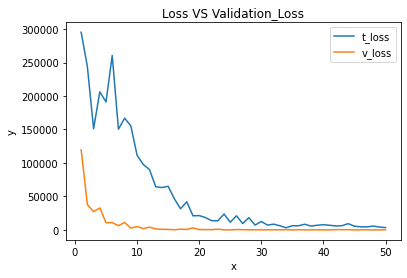

In [ ]:
#Open the graph
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('log_vgg_triplet_training_6_6.csv')
df[['epoch', 't_loss', 'v_loss']].plot(
    x='epoch',
    xlabel='x',
    ylabel='y',
    title='Loss VS Validation_Loss'
)

plt.show()

#https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

# 5.6 Training another way

In [ ]:
from tensorflow.keras import metrics

In [ ]:
target_shape = (224,224)
anchor_input = Input(name="anchor", shape=target_shape + (3,))
positive_input = Input(name="positive", shape=target_shape + (3,))
negative_input = Input(name="negative", shape=target_shape + (3,))

'''
#L2 normalize embeddings
distances = DistanceLayer()(
    tf.math.l2_normalize(vgg_face_embedding(anchor_input), axis=-1),
    tf.math.l2_normalize(vgg_face_embedding(positive_input), axis=-1),
    tf.math.l2_normalize(vgg_face_embedding(negative_input), axis=-1)
)



'''
distances = DistanceLayer()(
    vgg_face_embedding(anchor_input),
    vgg_face_embedding(positive_input),
    vgg_face_embedding(negative_input),
)



siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


In [ ]:
siamese_network.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 2622)         145002878   anchor[0][0]                     
                                                                 positive[0][0]             

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.
    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.
    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.2):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:
training_model = SiameseModel(siamese_network)
training_model.compile(optimizer=opt)

In [ ]:
csv_logger = CSVLogger('log_train_2622D_Softmax_3_6.csv', append=True, separator=',')

In [ ]:
History = training_model.fit(train_data,batch_size=32, epochs=100, validation_data=test_data, callbacks=[csv_logger]) 
train_loss = History.history['loss']
val_loss   = History.history['val_loss']

# 6. Save Model

In [ ]:
siamese_network.summary()

In [ ]:
#Removing just the CNN layer, the name "model_5" might be wrong, double check using the summary() of the siamese model
new_embedding = siamese_network.get_layer('model_5')

In [ ]:
new_embedding.summary()

In [ ]:
# Save weights
new_embedding.save('snn_gpu_trained_model_128D_preprocessed_1_6.h5')

In [ ]:
L1Dist

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('gpu_trained_model.h5', 
                                   custom_objects={'L1Dist':L1Dist})

In [ ]:
# View model summary
siamese_model.summary()

# 7. Sources

In [ ]:
"""
Sources:
https://morioh.com/p/a07857cbc76d
https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
https://keras.io/examples/vision/siamese_contrastive/ #For euclidean distance
https://keras.io/examples/vision/siamese_network/#inspecting-what-the-network-has-learned
https://github.com/keras-team/keras-io/blob/master/examples/vision/siamese_network.py
"""